In [61]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import json

import librosa
import math

import hmmlearn.hmm as hmm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from preprocessing import get_mfcc

from utils import  get_all_words

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1.Params

In [71]:
class_names = get_all_words(tiny=True)
print('Class names:', class_names)

n_mix = 3

states = [4,4,5,5,5,6,2,6,5,5,
          5,6,5,5,5,4,5,4,5,5,
          5,5,5,5,5,5,5,5,5,5,
          4,5,6,4,5,5,5,5,5,4,
          5,5,5,5,5,5,3,3,3,3,
          3,7]

df = pd.DataFrame(states, columns=["n_state"])

# Lưu vào file Excel
file_path = "../logs/state.xlsx"
df.to_excel(file_path, index=False, header=True, engine="openpyxl")



Class names: ['chu', 've', 'vao', 'tai', 'dau', 'cuoi', 'ke', 'truoc', 'dung', 'ngung', 'doc', 'tiep', 'lui', 'toi', 'tang', 'to', 'giam', 'nho', 'lai', 'lap', 'nhanh', 'cham', 'luu', 'xoa', 'huy', 'chay', 'xong', 'dung', 'sai', 'giup', 'gio', 'ngay', 'tuoi', 'co', 'khong', 'muc', 'bai', 'mot', 'hai', 'ba', 'bon', 'nam', 'sau', 'bay', 'tam', 'chin', 'a', 'e', 'i', 'o', 'u', 'thodia']


In [72]:
dataset_path = '../datasets/raw'

model_path = '../models'

In [73]:
def load_data(dataset_path: str, class_names: str):
    length = 0
    for cn in os.listdir(dataset_path):  # Lấy danh sách tất cả thư mục con trong dataset_path
        cn_path = os.path.join(dataset_path, cn)  # Đường dẫn đầy đủ tới thư mục con
        if os.path.isdir(cn_path):  # Kiểm tra nếu cn là một thư mục
            length += len(os.listdir(cn_path))  # Đếm số lượng tệp trong thư mục cn
    print('Total files:', length)

    X = {'train': {}, 'test': {}}
    y = {'train': {}, 'test': {}}

    all_data = {}
    all_labels = {}

    # for cname in class_names:
    #     file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
    #         os.path.join(dataset_path, cname)) if i.endswith('.wav')]
    #     data = [get_mfcc(file_path) for file_path in file_paths]
    #     all_data[cname] = data
    #     all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]

    for cname in class_names:
        i = class_names.index(cname)  # Xác định chỉ số của cname
        file_paths = []  # Danh sách lưu đường dẫn các tệp cho lớp hiện tại

        for folder in os.listdir(dataset_path):  # Duyệt qua tất cả các thư mục trong dataset_path
            folder_path = os.path.join(dataset_path, folder)
            if os.path.isdir(folder_path):  # Kiểm tra nếu folder là một thư mục
                files = sorted([f for f in os.listdir(folder_path) if f.endswith('.wav')])  # Lấy danh sách tệp .wav và sắp xếp
                if i < len(files):  # Kiểm tra nếu tệp thứ i tồn tại
                    file_path = os.path.join(folder_path, files[i]).replace('\\', '/')# Thêm tệp thứ i vào file_paths
                    file_paths.append(file_path)
        print(f'File_paths of {cname}:', file_paths)

        # Trích xuất đặc trưng MFCC và lưu dữ liệu
        data = [get_mfcc(file_path) for file_path in file_paths]
        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]


    for cname in class_names:
        x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.33,
            random_state=42
        )

        X['train'][cname] = x_train
        X['test'][cname] = x_test
        y['test'][cname] = y_test

    total_train = 0
    total_test = 0
    for cname in class_names:
        train_count = len(X['train'][cname])
        test_count = len(X['test'][cname])
        print(cname, 'train:', train_count, '| test:', test_count)
        total_train += train_count
        total_test += test_count
    print('train samples:', total_train)
    print('test samples', total_test)

    return X, y

In [74]:
X, y = load_data(dataset_path, class_names)

Total files: 1040
File_paths of chu: ['../datasets/raw/A/A01.wav', '../datasets/raw/B/B01.wav', '../datasets/raw/C/C01.wav', '../datasets/raw/D/D01.wav', '../datasets/raw/E/E01.wav', '../datasets/raw/F/F01.wav', '../datasets/raw/G/G01.wav', '../datasets/raw/H/H01.wav', '../datasets/raw/I/I01.wav', '../datasets/raw/J/J01.wav', '../datasets/raw/K/K01.wav', '../datasets/raw/L/L01.wav', '../datasets/raw/M/M01.wav', '../datasets/raw/N/N01.wav', '../datasets/raw/O/O01.wav', '../datasets/raw/P/P01.wav', '../datasets/raw/Q/Q01.wav', '../datasets/raw/R/R01.wav', '../datasets/raw/S/S01.wav', '../datasets/raw/T/T01.wav']
File_paths of ve: ['../datasets/raw/A/A02.wav', '../datasets/raw/B/B02.wav', '../datasets/raw/C/C02.wav', '../datasets/raw/D/D02.wav', '../datasets/raw/E/E02.wav', '../datasets/raw/F/F02.wav', '../datasets/raw/G/G02.wav', '../datasets/raw/H/H02.wav', '../datasets/raw/I/I02.wav', '../datasets/raw/J/J02.wav', '../datasets/raw/K/K02.wav', '../datasets/raw/L/L02.wav', '../datasets/ra

# 2. Training

In [75]:
def train(X: dict[str, dict], class_names: list[str], states: list[int], n_mix: int = 2):
    models = {}
    likelihoods = {}

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0
        trans_matrix = trans_matrix / (states[idx])

        # trans matrix
        print(cname)
        print(trans_matrix)
        
        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            n_mix=n_mix,
            verbose=False,
            n_iter=300,
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42
        )

        models[cname].fit(X=np.vstack(X['train'][cname]),
                                lengths=[x.shape[0] for x in X['train'][cname]])

        likelihoods[cname] = models[cname].monitor_.history

    return models, likelihoods

In [76]:
models, likelihoods = train(X, class_names, states, n_mix)

chu
[[0.125 0.125 0.    0.   ]
 [0.    0.125 0.125 0.   ]
 [0.    0.    0.125 0.125]
 [0.    0.    0.    0.25 ]]
ve
[[0.125 0.125 0.    0.   ]
 [0.    0.125 0.125 0.   ]
 [0.    0.    0.125 0.125]
 [0.    0.    0.    0.25 ]]
vao
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
tai
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
dau
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
cuoi
[[0.08333333 0.08333333 0.         0.         0.         0.        ]
 [0.         0.08333333 0.08333333 0.         0.         0.        ]
 [0.         0.         0.08333333 0.08333333 0.         0.        ]
 [0.         0.         0.         0.08333333 0.08333333 0.        ]
 [0.         0.         0.         0.         0.08333333 0.08333333]
 [0.         0.         0.         0.         0.         0.166666

Model is not converging.  Current: -188549.79606226808 is not greater than -188549.2069479259. Delta is -0.5891143421758898


lai
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
lap
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
nhanh
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
cham
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
luu
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
xoa
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
huy
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
chay
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
xong
[[0.1 0.1 0.  0.  0. ]
 [0.  0.

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\hmmlearn\hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


mot
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
hai
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
ba
[[0.125 0.125 0.    0.   ]
 [0.    0.125 0.125 0.   ]
 [0.    0.    0.125 0.125]
 [0.    0.    0.    0.25 ]]
bon
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
nam
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
sau
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
bay
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
tam
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0. ]
 [0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.  0.  0.  0.2]]
chin
[[0.1 0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.  0.

In [77]:
def show_prob(models: dict[str, hmm.GMMHMM], class_names: list[str]):
    for cname in class_names:
        print("\nMa trận chuyển tiếp trạng thái ẩn của \"" + cname +"\":")
        print(models[cname].transmat_)

show_prob(models, class_names)


Ma trận chuyển tiếp trạng thái ẩn của "chu":
[[0.8500213  0.         0.1499787  0.        ]
 [0.         0.94313274 0.         0.05686726]
 [0.10580628 0.01202043 0.88217329 0.        ]
 [0.0382597  0.         0.         0.9617403 ]]

Ma trận chuyển tiếp trạng thái ẩn của "ve":
[[0.87549656 0.         0.         0.12450344]
 [0.         0.93560834 0.06439166 0.        ]
 [0.02492555 0.0457618  0.91116306 0.01814958]
 [0.19520986 0.         0.02277802 0.78201212]]

Ma trận chuyển tiếp trạng thái ẩn của "vao":
[[0.88802186 0.05631074 0.0556674  0.         0.        ]
 [0.0154645  0.87900848 0.         0.10552702 0.        ]
 [0.         0.         0.94051057 0.         0.05948943]
 [0.         0.1013438  0.         0.8986562  0.        ]
 [0.05984338 0.         0.         0.         0.94015662]]

Ma trận chuyển tiếp trạng thái ẩn của "tai":
[[0.90010244 0.01140353 0.         0.00112968 0.08736435]
 [0.         0.91184512 0.         0.08815488 0.        ]
 [0.         0.         0.939787

# 3. Evaluation

In [78]:
def evaluation(model: dict, X: dict[str, dict], y: dict[str, dict], class_names: list[str]):
    import numpy as np
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # File Excel để lưu kết quả
    file_path = "../logs/evaluation.xlsx"
    # Danh sách để lưu kết quả
    results = []

    y_true = []
    y_pred = []
    
    # Duyệt qua từng lớp
    for cname in class_names:
        true_for_class = []
        pred_for_class = []
        
        # Duyệt qua từng mẫu của lớp
        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
            try:
                # Tính điểm số
                scores = [model[c].score(mfcc) for c in class_names]
                pred = np.argmax(scores)
                
                # Lưu kết quả
                true_for_class.append(target)
                pred_for_class.append(pred)
            except Exception as e:
                print(f"Error processing sample for class {cname}: {e}")

        # Cập nhật danh sách chung
        y_true.extend(true_for_class)
        y_pred.extend(pred_for_class)
        
        # Accuracy cho từng lớp
        if len(true_for_class) > 0:
            acc = np.sum(np.array(true_for_class) == np.array(pred_for_class)) / len(true_for_class)
            print(f'{cname}: {acc:.2f}')
            results.append([cname, f"{acc:.2f}"])
        else:
            print(f'{cname}: No data to evaluate.')
            results.append([cname, "No data to evaluate"])
    
    # Chuyển kết quả thành DataFrame
    results_df = pd.DataFrame(results, columns=["Class", "Accuracy"])
    # Ghi dữ liệu vào file Excel (luôn ghi đè)
    results_df.to_excel(file_path, index=False, header=True, engine="openpyxl")

    # Ma trận nhầm lẫn
    print('======')
    print('Confusion matrix:')
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    print(cm)

    # Accuracy tổng thể
    overall_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true) if len(y_true) > 0 else 0
    print('Accuracy:', overall_acc)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap="Blues")
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Error processing sample for class chu: startprob_ must sum to 1 (got nan)
Error processing sample for class chu: startprob_ must sum to 1 (got nan)
Error processing sample for class chu: startprob_ must sum to 1 (got nan)
Error processing sample for class chu: startprob_ must sum to 1 (got nan)
Error processing sample for class chu: startprob_ must sum to 1 (got nan)
Error processing sample for class chu: startprob_ must sum to 1 (got nan)
Error processing sample for class chu: startprob_ must sum to 1 (got nan)
chu: No data to evaluate.
Error processing sample for class ve: startprob_ must sum to 1 (got nan)
Error processing sample for class ve: startprob_ must sum to 1 (got nan)
Error processing sample for class ve: startprob_ must sum to 1 (got nan)
Error processing sample for class ve: startprob_ must sum to 1 (got nan)
Error processing sample for class ve: startprob_ must sum to 1 (got nan)
Error processing sample for class ve: startprob_ must sum to 1 (got nan)
Error processing s

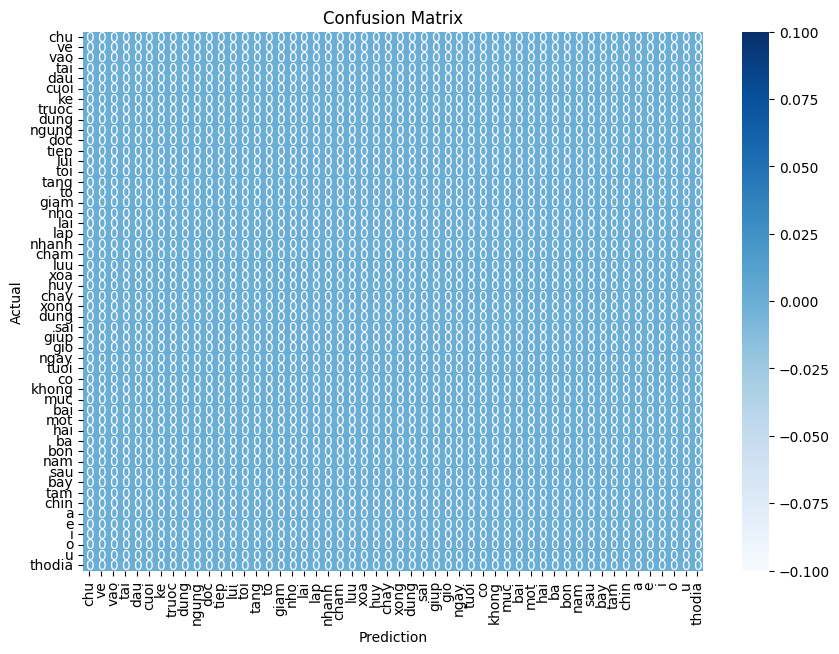

In [79]:
evaluation(models, X, y, class_names)

# 4. Save model

In [13]:
def save_model(models: dict, class_names, model_path: str, model_key: str):
    print(f'Saving models to {model_path}/{model_key}')
    if not os.path.exists(f'{model_path}/{model_key}'):
            os.makedirs(f'{model_path}/{model_key}')
    for cname in class_names:
        name = f'{model_path}/{model_key}/model_{cname}.pkl'
        
        with open(name, 'wb') as file:
            pickle.dump(models[cname], file)
    print(f'Save params to {model_path}/params.json')
    with open(f'{model_path}/{model_key}/params.json', 'w') as file:
        file.write(json.dumps({
            'n_states': [int(i) for i in states],
            'n_mix': n_mix,
        }))

In [14]:
save_model(models, class_names, model_path, f"demo")

Saving models to ../models/demo
Save params to ../models/params.json
